In [1]:
from sentence_transformers import SentenceTransformer

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
import numpy as np
import re

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

based on : https://pypi.org/project/sentence-transformers/

In [2]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [3]:
df = pd.read_csv('data/test_labeled.csv') 

sentences = pd.DataFrame(df)
sentences = sentences.drop_duplicates()

In [4]:
def preprocess_text(text):
    text = text.lower() 
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text) 
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    return text


sentences['cleaned_premise'] = sentences['premise'].apply(preprocess_text)
sentences['cleaned_hypothesis'] = sentences['hypothesis'].apply(preprocess_text)
print(sentences['cleaned_premise'])

0                                                        
1                                                        
2       et cela est en grande partie d au fait que les...
3                                                  imaamp
4                                                        
                              ...                        
5190                                                     
5191    the  rock  has a soft texture and can be bough...
5192                                                     
5193    isnt it i can remember ive only been here eigh...
5194    in hong kong you can have a plate or even a wh...
Name: cleaned_premise, Length: 5195, dtype: object


In [5]:
embeddings_premises = model.encode(sentences['cleaned_premise'].tolist(), show_progress_bar=True)
embeddings_hypotheses = model.encode(sentences['cleaned_hypothesis'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/163 [00:00<?, ?it/s]

Batches:   0%|          | 0/163 [00:00<?, ?it/s]

In [6]:
print(embeddings_premises.shape)
print(embeddings_hypotheses.shape)

(5195, 384)
(5195, 384)


We concatenate the two vectors for training.
Next, for better results, we can chose to concatenate the training vector with their absolute difference

In [7]:
X = np.concatenate([embeddings_premises, embeddings_hypotheses, np.abs(embeddings_premises - embeddings_hypotheses)], axis=1)
y = sentences['label'].values

print(X.shape)
print(y.shape)

(5195, 1152)
(5195,)


In [8]:
indices = np.arange(len(X))

X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X, y, indices, test_size=0.2, random_state=42
)

clf =  RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4156, 1152)
(4156,)
(1039, 1152)
(1039,)


In [10]:
y_pred = clf.predict(X_test)

premise_predicted = sentences.iloc[test_indices]['premise']
label_real = sentences.iloc[test_indices]['label']
hypothesis_predicted = sentences.iloc[test_indices]['hypothesis']

for premise,hypothesis, label_real, label_pred in zip(premise_predicted.head(30),hypothesis_predicted.head(30),label_real.head(30), y_pred[:30]):
    print(f"Premise: {premise}\nHypothesis: {hypothesis}\nReal label: {label_real}\nPredicted label: {label_pred}\nProximity: {clf.predict_proba([X_test[0]])}\n")   
    
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Premise: LSC set a deadline of October 1, 1998, for submission of state planning reports.
Hypothesis: LSC has a deadline of October 1,1998 to submit state planning reports.
Real label: 0
Predicted label: 0
Proximity: [[0.531  0.1715 0.2975]]

Premise: Turizm ofisleri L'Estrie bölgesini yeniden adlandırmaya çalıştılar ancak en militan Quebecli bile Cantons de l'Est'in doğrudan, daha yaklaşık çevirisini tercih eder.
Hypothesis: Turizmciler eskisi kulağa çirkin geldiğinden, bölgenin daha iyi bir isme ihtiyacı olduğunu düşünüyor.
Real label: 1
Predicted label: 2
Proximity: [[0.531  0.1715 0.2975]]

Premise: Given the limits on the WTO's jurisdiction, it was probably unreasonable of Kodak to expect a real victory.
Hypothesis: Kodak was naive and is still just a baby of a company.
Real label: 1
Predicted label: 2
Proximity: [[0.531  0.1715 0.2975]]

Premise: uh-huh yeah yeah they're good
Hypothesis: They are all right but not great.
Real label: 1
Predicted label: 2
Proximity: [[0.531  0.1715

Test of a Dense model

In [11]:
num_classes = 3
input_dim = X.shape[1]

Best model found :

In [12]:
model = Sequential([
    Input(shape=(input_dim,)),
    Dense(256, activation='relu'),
    Dropout(0.7),
    Dense(3, activation='softmax')  # 3 classes : contradiction, neutral, entailment
])

2025-05-05 13:02:16.529680: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Other model :

In [13]:
model2 = Sequential([
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax') 
])

In [14]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.2)

Epoch 1/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3688 - loss: 1.0976 - val_accuracy: 0.3822 - val_loss: 1.0791
Epoch 2/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4266 - loss: 1.0658 - val_accuracy: 0.4423 - val_loss: 1.0558
Epoch 3/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4736 - loss: 1.0291 - val_accuracy: 0.4387 - val_loss: 1.0437
Epoch 4/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4942 - loss: 0.9994 - val_accuracy: 0.4207 - val_loss: 1.0426
Epoch 5/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5196 - loss: 0.9677 - val_accuracy: 0.4531 - val_loss: 1.0386
Epoch 6/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5361 - loss: 0.9410 - val_accuracy: 0.4339 - val_loss: 1.0443
Epoch 7/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5469 - loss: 0.9234 - val_accuracy: 0.4507 - val_loss: 1.0395
Epoch 8/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5755 - loss: 0.8866 - val_accuracy: 0.4351 - v

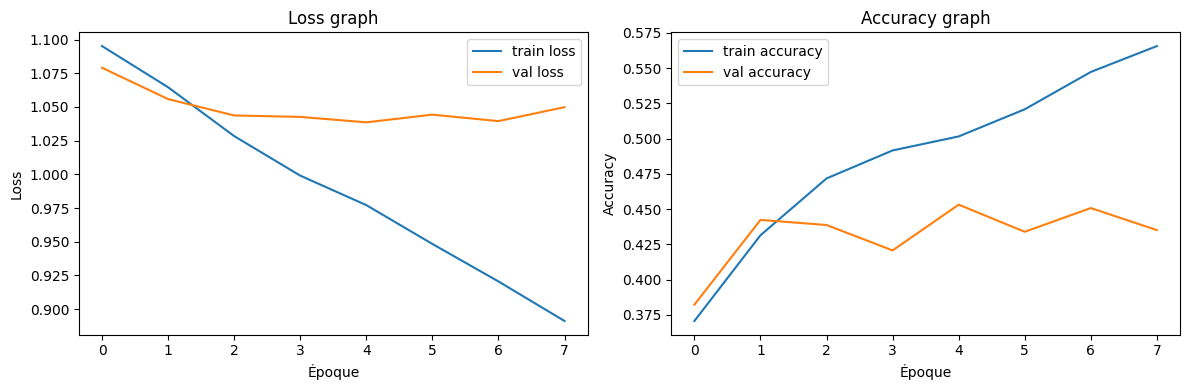

In [15]:
# loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss graph')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()

# accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy graph')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
y_pred_classes = model.predict(X_test)
y_pred = np.argmax(y_pred_classes, axis=1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [17]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 41.19%


In [18]:
results=[]
for i in range(10):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.2)
    y_pred_classes = model.predict(X_test)
    y_pred = np.argmax(y_pred_classes, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    results.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    
print(f"Mean Accuracy: {np.mean(results) * 100:.2f}%")

Epoch 1/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5965 - loss: 0.8625 - val_accuracy: 0.4651 - val_loss: 1.0530
Epoch 2/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6168 - loss: 0.8283 - val_accuracy: 0.4411 - val_loss: 1.0607
Epoch 3/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6270 - loss: 0.8053 - val_accuracy: 0.4363 - val_loss: 1.0662
Epoch 4/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6427 - loss: 0.7813 - val_accuracy: 0.4519 - val_loss: 1.0793
Epoch 5/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6471 - loss: 0.7622 - val_accuracy: 0.4555 - val_loss: 1.0846
Epoch 6/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6665 - loss: 0.7217 - val_accuracy: 0.4531 - val_loss: 1.1004
Epoch 7/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6706 - loss: 0.7241 - val_accuracy: 0.4627 - val_loss: 1.1015
Epoch 8/8
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6873 - loss: 0.6870 - val_accuracy: 0.4495 - v

In [19]:
print(results)
print(np.mean(results))

[0.4340712223291627, 0.42059672762271416, 0.39268527430221367, 0.40423484119345526, 0.39846005774783444, 0.4051973051010587, 0.40230991337824834, 0.3994225216554379, 0.38787295476419636, 0.3897978825794033]
0.4034648700673725
